In [ ]:
import pandas as pd
import numpy as np

# 시각화
import seaborn as sns

# 경고 메시지 무시
import warnings
warnings.filterwarnings(action='ignore') 

# 버전 확인
print('Pandas : %s'%(pd.__version__))
print('seaborn : %s'%(sns.__version__))
!python --version

Pandas : 1.3.5
seaborn : 0.11.2
Python 3.7.14


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
loan = pd.read_csv('/content/drive/MyDrive/2022Bigcontest/data/loan_result.csv')
log = pd.read_csv('/content/drive/MyDrive/2022Bigcontest/data/log_data.csv')
user = pd.read_csv('/content/drive/MyDrive/2022Bigcontest/data/user_spec.csv')

In [ ]:
user.isna().sum()

application_id                               0
user_id                                      0
birth_year                               12961
gender                                   12961
insert_time                                  0
credit_score                            105115
yearly_income                               90
income_type                                 85
company_enter_month                     171760
employment_type                             85
houseown_type                               85
desired_amount                              85
purpose                                     85
personal_rehabilitation_yn              587461
personal_rehabilitation_complete_yn    1203354
existing_loan_cnt                       198556
existing_loan_amt                       313774
dtype: int64

In [ ]:
###### birth_year #####
birth_year_mean = user['birth_year'].mean()
user['birth_year'] = user['birth_year'].fillna('없음')

# 전처리할 데이터 재생성
bir = user.groupby('user_id')['birth_year'].apply(set).reset_index()
bir['len'] = bir['birth_year'].apply(lambda x:len(x))

# 0을 지워주는 함수 생성
def remove0(x):
    if len(x) == 2: 
        x_ = x.remove('없음')
        return x_
    else: return x

# 적용
bir['birth_year'].apply(remove0)
bir['year'] = bir['birth_year'].apply(lambda x:list(x)[0])

# 없음을 평균으로 채워줌
bir['year'] = bir['year'].apply(lambda x:birth_year_mean if x == '없음' else x)

In [ ]:
# 딕셔너리로 변환하여 저장
birth_year = {x:y for x,y in zip(bir['user_id'], bir['year'])}

# 적용하여 변환
user['birth_year'] = user['user_id'].apply(lambda x:birth_year[x])

In [ ]:
###### gender #####
user['gender'] = user['gender'].fillna('없음')

# 전처리할 데이터 재생성
g = user.groupby('user_id')['gender'].apply(set).reset_index()
g['len'] = g['gender'].apply(lambda x:len(x))

# 0을 지워주는 함수 생성
def remove2(x):
    if len(x) == 2: 
        x_ = x.remove('없음')
        return x_
    else: return x

# 적용
g['gender'].apply(remove2)
g['g'] = g['gender'].apply(lambda x:list(x)[0])
g['g'] = g['g'].apply(lambda x:1 if x == '없음' else x)

# 딕셔너리로 변환하여 저장
gender = {x:y for x,y in zip(g['user_id'], g['g'])}

# 적용하여 변환
user['gender'] = user['user_id'].apply(lambda x:gender[x])

In [ ]:
# na값을 확인 하였을 때, personal_rehabilitation_complete_yn의 값이 높은데, 이는 개인 회생자가 아닌 사람도 포함 돼있기 때문으로 보임
## na중 personal_rehabilitation_yn의 값이 0인 값은 개인회생자 아님 등으로 채워야할 듯함
user[user['personal_rehabilitation_complete_yn'].isna()]['personal_rehabilitation_yn'].unique()

array([ 0., nan])

In [ ]:
user.query('personal_rehabilitation_yn == 0')['personal_rehabilitation_complete_yn'].value_counts()

0.0    178149
1.0         4
Name: personal_rehabilitation_complete_yn, dtype: int64

In [ ]:
user.query('personal_rehabilitation_yn == 1')['personal_rehabilitation_complete_yn'].value_counts()

0.0    11361
1.0     1348
Name: personal_rehabilitation_complete_yn, dtype: int64

In [ ]:
# 기록이 있으면 개인회생자, 없으면 아닌 사람으로 기록
user['personal_rehabilitation_yn'] = user['personal_rehabilitation_complete_yn'].apply(lambda x:1 if x in [0,1] else 0)
# 나머지 기록이 na인 값은 전부 개인회생자가 아닌 것으로 확인함 -> 2( 개인회생자아님 )로 채워줌
user['personal_rehabilitation_complete_yn'] = user['personal_rehabilitation_complete_yn'].fillna(2)

In [ ]:
# company_enter_month에 대한 na값은 입사 년월을 입력하지 못하는 사람들이 대부분임
## 입사년월이 없는 사람 (ex)개인 사업, 소득이 회사가 아닌 경우 등 )
## 다른 옵션으로 채워야할듯함
user[user['company_enter_month'].isna()]['income_type'].value_counts()

OTHERINCOME        171665
EARNEDINCOME            7
PRIVATEBUSINESS         3
Name: income_type, dtype: int64

In [ ]:
# OTHERINCOME을 제외하면 na값이 적기 때문에 입사년도 없음으로 채워줌
user['company_enter_month'] = user['company_enter_month'].fillna('입사년도 없음')

In [ ]:
# 68018명의 사람들의 신용정보 확인 불가능
user[['user_id', 'credit_score']].drop_duplicates(subset='user_id').isna().sum()

user_id             0
credit_score    68018
dtype: int64

In [ ]:
# 신용 점수가 있는 고객들은 해당 고객이 가진 신용 점수의 평균으로 채워줌
user['credit_score'] = user['credit_score'].fillna(user.groupby('user_id')['credit_score'].transform('mean'))

In [ ]:
# 채운 후에도 na값인 경우는 신용 점수를 확인한 적이 한번도 없는 고객임
user[user['credit_score'].isna()].groupby('user_id')['credit_score'].count().unique()

array([0])

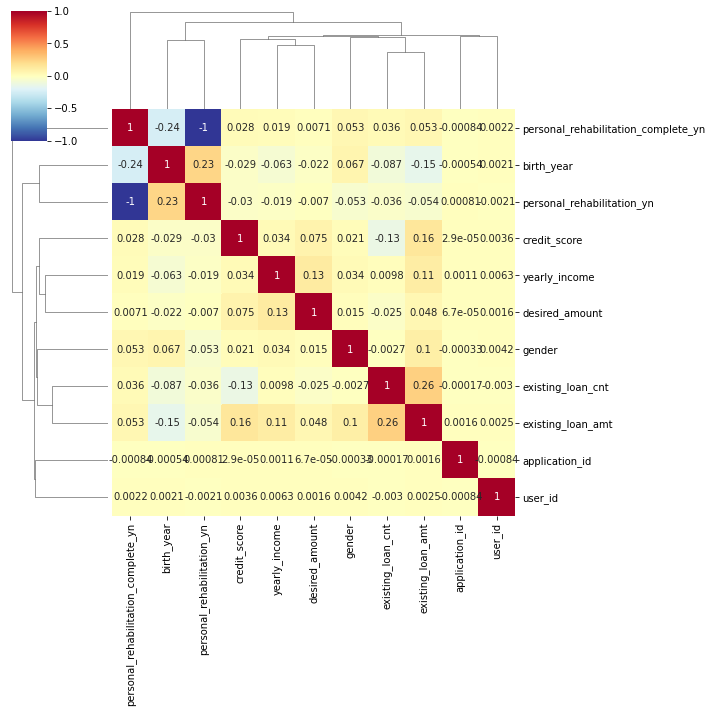

In [ ]:
# 컬럼들과 credit score간의 상관관계를 시각화해 보았으나 의미 X 그냥 평균으로 채움

sns.clustermap(user.corr(), 
               annot = True,      # 실제 값 화면에 나타내기
               cmap = 'RdYlBu_r',  # Red, Yellow, Blue 색상으로 표시
               vmin = -1, vmax = 1, #컬러차트 -1 ~ 1 범위로 표시
              )

In [ ]:
# 평균으로 채워줌
user['credit_score'] = user['credit_score'].fillna(user['credit_score'].mean())

In [ ]:
# existing_loan_cnt의 값이 0인 행이 없는 것으로 보아 na인 경우는 기대출수가 0이지 않을까 하는 추축
user[user['existing_loan_cnt'] == 0]

,application_id,user_id,birth_year,gender,insert_time,credit_score,yearly_income,income_type,company_enter_month,employment_type,houseown_type,desired_amount,purpose,personal_rehabilitation_yn,personal_rehabilitation_complete_yn,existing_loan_cnt,existing_loan_amt


In [ ]:
# existing_loan_cnt가 na인 값의 amt는 모두 na인 모습을 보임
user[user['existing_loan_cnt'].isna()][['existing_loan_cnt','existing_loan_amt']].isna().sum()

existing_loan_cnt    198556
existing_loan_amt    198556
dtype: int64

In [ ]:
# existing_loan_cnt와 existing_loan_amt의 수가 na인 값은 0으로 채워줌
user['existing_loan_cnt'] = user['existing_loan_cnt'].fillna(0)
user['existing_loan_amt'] = user['existing_loan_amt'].fillna(0)

In [ ]:
# 연소득이 na인 값의 소득 경로를 확인해 본 결과 na인 값이 85개, 다른 수익 4, 프리랜서가 1인 모습을 보임
## -> 즉, na인 것은 연소득이 없다는 뜻임
user[user['yearly_income'].isna()]['income_type'].value_counts()

OTHERINCOME    4
FREELANCER     1
Name: income_type, dtype: int64

In [ ]:
# 0으로 채워줌
user['yearly_income'] = user['yearly_income'].fillna(0)
user['income_type'] = user['income_type'].fillna('직장없음')

In [ ]:
# employment_type의 경우 company_enter_month의 값이 입사년도없음임
user[user['employment_type'].isna()]['company_enter_month'].unique()

array(['입사년도 없음'], dtype=object)

In [ ]:
# 입사년도가 없다는 것은 기타이기 때문에 기타로 채워줌
user['employment_type'] = user['employment_type'].fillna('기타')

In [ ]:
# houseown_type이 na인 값은 그냥 귀찮아서 안찍은듯함
user['houseown_type'].unique()

array(['자가', '기타가족소유', '전월세', '배우자', nan], dtype=object)

In [ ]:
## -> 정보없음으로 채워줌
user['houseown_type'] = user['houseown_type'].fillna('정보없음')

In [ ]:
# 이 경우도 선택을 그냥 하지 않은 경우이기 때문에 최빈값으로 채워줌
## 단순한 궁금증으로 인하여 선택을 한 경우라고 판단 -> 가장 많이 원하는 금액으로 채움
user['desired_amount'] = user['desired_amount'].fillna(user['desired_amount'].mode()[0])

In [ ]:
# 목적 또한 위와 같음
## 최빈값으로 채움
user['purpose'] = user['purpose'].fillna(user['purpose'].mode()[0])

In [ ]:
user.isna().sum()

application_id                         0
user_id                                0
birth_year                             0
gender                                 0
insert_time                            0
credit_score                           0
yearly_income                          0
income_type                            0
company_enter_month                    0
employment_type                        0
houseown_type                          0
desired_amount                         0
purpose                                0
personal_rehabilitation_yn             0
personal_rehabilitation_complete_yn    0
existing_loan_cnt                      0
existing_loan_amt                      0
dtype: int64

In [ ]:
# 데이터가 중복인 경우가 25개 존재하여 삭제해줌
len(loan[loan.duplicated()])

26

In [ ]:
# 중복 제거하여 데이터 선언
loan = loan.drop_duplicates()

- 결측값 처리

In [ ]:
loan.isna().sum()

application_id                 0
loanapply_insert_time          0
bank_id                        0
product_id                     0
loan_limit                  7495
loan_rate                   7495
is_applied               3257223
dtype: int64

In [ ]:
# loan_limit과 loan_rate는 동일한 행에서 na값을 가짐을 확인
loan[loan['loan_limit'].isna()]['loan_rate'].unique()

array([nan])

In [ ]:
# 타겟값에 대한 확인을 위해 월별로 확인
loan['month'] = loan['loanapply_insert_time'].apply(lambda x:int(x[5:7]))

# train data의 경우 loan_limit과 loan_rate가 na인 경우 타겟값이 모두 1임을 알 수 있음
loan[(loan['loan_limit'].isna()) & (loan['month'] != 6)]['is_applied'].value_counts()

1.0    5738
Name: is_applied, dtype: int64

In [ ]:
# 전체 타겟값 대비 1% 정도가 위와 같은 모습을 보임
## -> 비슷한 형태를 띄는 행으로 결측값 대체
loan['is_applied'].value_counts()

0.0    9709673
1.0     560441
Name: is_applied, dtype: int64

    - loan_rate

In [ ]:
# 일부 행만 null인 경우 결측치를 product별 평균
product_list = loan[loan['loan_limit'].isna()]['product_id'].unique()

for i in product_list:
    len_rate = loan[loan['product_id'] == i]['loan_rate'].unique()
    
    if len(len_rate) > 1:
        loan.loc[(loan['product_id'] == i) & (loan['loan_rate'].isna()), 'loan_rate'] = round(np.nanmean(len_rate), 1)

        
# 모두 null인 경우 결측치를 application별 평균
loan['loan_rate'] = loan['loan_rate'].fillna(loan.groupby('application_id')['loan_rate'].transform('mean'))

# application이 하나인 데이터 최빈값 대체
loan['loan_rate'] = loan['loan_rate'].fillna(loan['loan_rate'].mode()[0])

    - loan_limit

In [ ]:
# loan_limit 결측치를 application별로 평균
loan['loan_limit'] = loan['loan_limit'].fillna(loan.groupby('application_id')['loan_limit'].transform('mean'))

# application이 하나인 결측치 최빈값으로
loan['loan_limit'] = loan['loan_limit'].fillna(loan['loan_limit'].mode()[0])

In [ ]:
loan.isna().sum()

application_id                 0
loanapply_insert_time          0
bank_id                        0
product_id                     0
loan_limit                     0
loan_rate                      0
is_applied               3257223
month                          0
dtype: int64

## 변수 생성

- user

In [ ]:
### 대출 이력 ###
# 대출 이력이 있는 고객은1 없는 고객은 0으로 채워줌
true_list = loan[loan['is_applied'] == 1]['application_id'].unique()
user['loan_history'] = user['application_id'].apply(lambda x:1 if x in true_list else 0)

In [ ]:
### insert time 날짜 변경 ### 
# insert time : 한도조회 당시 시간
user['insert_time'] = pd.to_datetime(user['insert_time'])

In [ ]:
### 나이 ###
# 현시점의 나이를 계산해서 변수로 생성
user['age'] = user['birth_year'].apply(lambda x:2022 - x if x!= '없음' else x)

In [ ]:

### 연령대 ###
user['age_group'] = user['age'].apply(lambda x:f'{str(x)[0]}0대' if x != '없음' else x)

In [ ]:
### 신용등급 ###
# finda 신용등급은 코리아크레딧뷰로(KCB)사용
def credit_rating(x):
    if x >= 942:return 1
    elif x >= 891:return 2
    elif x >= 832:return 3
    elif x >= 768:return 4
    elif x >= 698:return 5
    elif x >= 630:return 6
    elif x >= 530:return 7
    elif x >= 454:return 8
    elif x >= 335:return 9
    else:return 10
    
user['credit_rating'] = user['credit_score'].apply(credit_rating)

In [ ]:
### 소득등급 ###
# 상세 소득수준(ex.연령대별 평균과 비교) or 세분화된 소득분위(ex.10등급으로 세분, 장학재단에서 사용하는 소득분위) 추가
percent = user['yearly_income'].describe()

def income_rating(x):
    if x < percent[4]:return 4
    elif x < percent[5]:return 3
    elif x < percent[6]:return 2
    else:return 1

user['income_rating'] = user['yearly_income'].apply(income_rating)

In [ ]:
### 근속년수 ###
user['service_year'] = user['company_enter_month'].apply(lambda x:2022- int(str(x)[:4]) + 1 if x != '입사년도 없음' else x)

In [ ]:
### 기대출 평균 금액 ###
user['avg_existing_loan_amt'] = user['existing_loan_amt'] / user['existing_loan_cnt']
user['avg_existing_loan_amt'] = user['avg_existing_loan_amt'].fillna(user['avg_existing_loan_amt'].mean())

In [ ]:
### 대출 조회 건수 ###
count = user.groupby('user_id')['application_id'].count()
user['application_count'] = user['user_id'].apply(lambda x : count[x])

In [ ]:
### 신용평가 시간 ###
def insert_classification(x):
    if 2 <= x <= 5:return "새벽"
    elif x <= 9:return "아침"
    elif x <= 13:return "점심"
    elif x <= 18:return "낮"
    elif x <= 22:return "저녁"
    else:return "밤"

user['insert_classification'] = user['insert_time'].dt.hour.apply(insert_classification)

In [ ]:
### income_type 별 소득 수준 ###
income_type = user.groupby('income_type')['yearly_income'].agg('median')

user['income_income_level'] = user.apply(lambda x: "직장없음" if x['income_type'] == "직장없음" else 
                                         ("평균 미만" if x['yearly_income'] < income_type[x['income_type']] else "평균 이상"), axis = 1)

In [ ]:
### 연소득 대비 대출 희망금액 비율 ###
user['income_desired_ratio'] = user['desired_amount'] / user['yearly_income']
# 나누는 값이 0인 경우 처리
user['income_desired_ratio'] = user['income_desired_ratio'].fillna(user['income_desired_ratio'].mean())

In [ ]:
### 연소득 대비 기대출 금액 비율 ###
user['income_existing_ratio'] = user['existing_loan_amt'] / user['yearly_income']
# 나누는 값이 0인 경우 처리
user['income_existing_ratio'] = user['income_existing_ratio'].fillna(user['income_existing_ratio'].mean())

- loan

In [ ]:
### loanapply_insert_time 날짜 변경 ###
loan['loanapply_insert_time'] = pd.to_datetime(loan['loanapply_insert_time'])

In [ ]:
import gc
gc.collect()

88

## 데이터 병합 및 저장

In [ ]:
# 데이터 병합
data = pd.merge(loan, user, on = "application_id").reset_index(drop = True)
# 예측을 위한 pk는 인덱스이기 때문에 불러올때 인덱스를 컬럼으로 가져옴
data = data.reset_index()

In [ ]:
# 다양한 type의 데이터가 존재하는 변수를 모두 str로 통일해줌
data['company_enter_month'] = data['company_enter_month'].astype(str)
data['service_year'] = data['service_year'].astype(str)

# datetime 인코딩 문제로 object로 변경
data['loanapply_insert_time'] = data['loanapply_insert_time'].astype(str)
data['insert_time'] = data['insert_time'].astype(str)

In [ ]:
data.to_csv('/content/drive/MyDrive/2022Bigcontest/data/data.csv', index=False)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13527224 entries, 0 to 13527223
Data columns (total 37 columns):
 #   Column                               Dtype  
---  ------                               -----  
 0   index                                int64  
 1   application_id                       int64  
 2   loanapply_insert_time                object 
 3   bank_id                              int64  
 4   product_id                           int64  
 5   loan_limit                           float64
 6   loan_rate                            float64
 7   is_applied                           float64
 8   month                                int64  
 9   user_id                              int64  
 10  birth_year                           float64
 11  gender                               float64
 12  insert_time                          object 
 13  credit_score                         float64
 14  yearly_income                        float64
 15  income_type                   

In [1]:
import os
import pandas as pd
import numpy as np
import gc

import matplotlib.pyplot as plt
from scipy import stats# Imports
import torch

import torchvision
import torch.nn as nn

import torch.nn.functional as F

from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.preprocessing import LabelEncoder

In [2]:
gc.collect()

22

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
data = pd.read_csv('/content/drive/MyDrive/2022Bigcontest/data/data.csv')

In [4]:
train = data[data['is_applied'].isna() == False].reset_index(drop=True)
test = data[data['is_applied'].isna()].reset_index(drop=True)

In [5]:
# 범주형 변수와 수치형 변수를 분리
## train
cat_feature_tr = train.iloc[:,1:].select_dtypes(include=['object']).columns.to_list()
num_feature_tr = train.iloc[:,1:].select_dtypes(exclude='object').columns.to_list() 
## test
#cat_feature_val = x_valid.iloc[:,1:].select_dtypes(include=['object']).columns.to_list()
#num_feature_val = x_valid.iloc[:,1:].select_dtypes(exclude='object').columns.to_list()

In [6]:
# Labelencoder
encoder = LabelEncoder()
encoded_cat_tr = []
encoded_cat_val = []
for f in cat_feature_tr:
    encoder = encoder.fit(train.reset_index(drop=True)[f])
    encoded_cat_tr.append(pd.DataFrame(encoder.transform(train[f]),columns = [f])) # train
    #encoded_cat_val.append(pd.DataFrame(encoder.transform(x_valid[f]),columns = [f])) # test

# 합쳐줌
cat_tr = pd.concat(encoded_cat_tr, axis = 1) # train
#cat_val = pd.concat(encoded_cat_val, axis = 1) # test

In [7]:
# 인코딩 이후 수치형 변수와 범주형 변수를 합쳐줌
x_train_imp = pd.concat([train['index'].reset_index(drop=True), cat_tr], axis=1)
#x_val_imp = pd.concat([x_valid['index'].reset_index(drop=True), cat_val], axis=1)

In [8]:
df_train = pd.concat([x_train_imp, train[num_feature_tr].reset_index(drop=True)], axis=1)
#x_valid = pd.concat([x_val_imp, x_valid[num_feature_val].reset_index(drop=True)], axis=1)

In [9]:
del x_train_imp, cat_tr, encoded_cat_tr

In [10]:
inputs = df_train.drop(['is_applied'], axis=1).values
targets = df_train[['is_applied']].values

inputs.shape, targets.shape

((10270001, 36), (10270001, 1))

In [11]:
val_1 = int(0.8*inputs.shape[0])
val_2 = inputs.shape[0] - val_1
val_1, val_2

(8216000, 2054001)

In [12]:
batch_size = 2048
TARGET_COLUMN = 'is_applied'
input_size=inputs.shape[1]
output_size=1

In [13]:
del train, df_train
gc.collect()

154

In [15]:
dataset = TensorDataset(torch.tensor(inputs, dtype=torch.float32), torch.tensor(targets, dtype=torch.float32))
train_ds, val_ds = random_split(dataset, [val_1, val_2])

train_loader = DataLoader(train_ds, batch_size, shuffle=False) # future predict karna hai na
val_loader = DataLoader(val_ds, batch_size*2)

In [16]:
del train_ds, val_ds, dataset, inputs, targets
gc.collect()

44

In [17]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [18]:
torch.cuda.is_available()

True

In [19]:
device = get_default_device()
device

device(type='cuda')

In [20]:
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(train_loader, device)

In [21]:
class My_Kaggle_Model(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Activation functions have been chosen either as SiLU (called as Swish in Keras), and LeakyReLU
        # I have used them in alternate, please comment if this is a good practice or not!
        self.layers = nn.Sequential(nn.Linear(input_size, 64), 
                                    nn.BatchNorm1d(64), 
                                    nn.SiLU(), 
                                    
                                    nn.Linear(64, 128), 
                                    nn.BatchNorm1d(128), 
                                    # nn.LeakyReLU(0.1), 
                                    nn.SiLU(),
                                    nn.Dropout(0.4),
                                    
                                    # nn.Linear(128, 256), 
                                    # nn.BatchNorm1d(256), 
                                    # nn.SiLU(), 
                                    # nn.Dropout(0.4),
                                    
                                    # nn.Linear(256, 512), 
                                    # nn.BatchNorm1d(512), 
                                    # # nn.LeakyReLU(0.1),
                                    # nn.SiLU(),
                                    # nn.Dropout(0.4), 
                                    
                                    # nn.Linear(512, 256), 
                                    # nn.BatchNorm1d(256), 
                                    # nn.SiLU(),
                                    # nn.Dropout(0.4),
                                    
                                    # nn.Linear(256, 128), 
                                    # nn.BatchNorm1d(128), 
                                    # # nn.LeakyReLU(0.1),
                                    # nn.SiLU(),
                                    # nn.Dropout(0.4),
                                    
                                    nn.Linear(128, 8), 
                                    nn.BatchNorm1d(8), 
                                    nn.SiLU(), 
                                    nn.Dropout(0.4),
                                    
                                    nn.Linear(8, 1),
                                    nn.Sigmoid()  
                                  )
    
        
    def forward(self, x):
        return self.layers(x)
    
    def training_step(self, batch):
        torch.cuda.empty_cache()
        gc.collect()
        inputs, targets = batch 
        inputs.to(device)
        targets.to(device)
        
        out = self(inputs)                 # Generate predictions
        criterion = nn.BCELoss()
        loss = criterion(out, targets)    # Calculate loss
        #loss = nn.BCEWithLogitsLoss()
        
        return loss
        #return loss(out, targets)

    def validation_step(self, batch):
        torch.cuda.empty_cache()
        gc.collect()
        inputs, targets = batch 
        inputs.to(device)
        targets.to(device)
        
        out = self(inputs)                 # Generate predictions
        criterion = nn.BCELoss()
        loss = criterion(out, targets)    # Calculate loss
        #loss = nn.BCEWithLogitsLoss()
        
        return {'val_loss': loss.detach()}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        return {'val_loss': epoch_loss.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}".format(epoch, result['train_loss'], result['val_loss']))
    
model = My_Kaggle_Model()

In [22]:
# shift model to GPU
model = to_device(model, device)

In [23]:
def evaluate(model, val_loader):
    model.eval()  # Setting to eval mode makes sure that dropouts are 'frozen'
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    #torch.autograd.set_detect_anomaly(True)
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train() # Setting to train mode
        train_losses = []
        
        for (i,batch) in enumerate(train_loader):
            torch.cuda.empty_cache()
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            if (i%200 == 0): print('batch number -- ', i)
            
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
        
#         # Early Stopping
#         if (result['valid_loss'][epoch] > result['valid_loss'][epoch - 1]) & (epoch >0):
#             trigger_times += 1
#             print('trigger times ', trigger_times)
            
#             if trigger_times >= patience:
#                 print('Early stopping!\nStart to test process.')
#                 return model
#         else:
#             print('trigger times: 0')
#             trigger_times = 0
            
    return history

In [24]:
train_loader.device, val_loader.device

(device(type='cuda'), device(type='cuda'))

In [25]:
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [27]:
history = fit(1, 1e-1, model, train_loader, val_loader, opt_func=torch.optim.Adam)

RuntimeError: ignored

In [ ]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');
history

In [ ]:
torch.cuda.empty_cache() # just to clear some GPU cache memory

In [ ]:
model_pred=[]
targets=[]
for batch in val_loader:
    model.eval()
    data, target = batch
    print('data.shape', data.shape)
    print('data.device', data.device)
    preds = model(data)
    model_pred += preds.tolist()
    targets.append(batch[1])
    print('preds.shape', preds.shape)

In [ ]:
pred = []
for i in model_pred:
  pred.append(i[0])

In [ ]:
t = []
for i in targets:
  for j in i:
    t.append(j.cpu().numpy()[0])

In [ ]:
p = pd.DataFrame({'pred' : pred,
                  'target' : t})

In [ ]:

p.head()

In [ ]:
p.describe()